In [305]:
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
from shapely.geometry import Point, shape
from shapely.geometry.polygon import Polygon
from pyproj import Transformer, CRS
import pandas as pd
import requests
import json
import time
import os
import fiona

In [ ]:
ELEVATION_API_URL = 'https://api.jawg.io/elevations'
ELEVATION_API_TOKEN = 'Od4CHFcUVhDZq9WtJgUq0BGqde9jskuoU0kUskwXdaz6aF3K3YVyg9zl6CUpmDD6'

In [225]:
fp = 'shp/terre_shp.shp'

In [277]:
shp = fiona.open(fp)

In [278]:
perimeter = shp[33]['geometry']['coordinates'][0]

In [279]:
transformer = Transformer.from_crs(shp.crs['init'],"epsg:4326")

In [280]:
points = [transformer.transform(point[0],point[1]) for point in perimeter]

In [284]:
polygon = Polygon(points)
min_lat, min_lon, max_lat, max_lon = polygon.bounds

In [285]:
lon_range = abs(max_lon-min_lon)
lat_range = abs(max_lat-min_lat)

In [286]:
lat_bins = 75
lon_bins = 300

In [287]:
lat_incr = lat_range/lat_bins
lon_incr = lon_range/lon_bins

In [295]:
data = []
total_break = 0
for y in range(lat_bins):
    lat_bin_min = min_lat + y*lat_incr
    lat_bin_max = min_lat + (y+1)*lat_incr

    lon_bin_all = [point[1] for point in points if point[0] > lat_bin_min and point[0] < lat_bin_max]
    
    lon_bin_max = max(lon_bin_all)
    lon_bin_min = min(lon_bin_all)
    lon_bin_range = lon_bin_max-lon_bin_min
    lon_bin_incr = lon_bin_range/lon_incr
    lon_bin_incr_cnt = int(lon_bin_incr)
    
    line_break = False
    break_cnt = 0
    for x in range(lon_bin_incr_cnt):
        point_lat = round(lat_bin_min,6)
        point_lon = round(lon_bin_min+x*lon_incr,6)
        curr_point = Point(point_lat,point_lon)
        check = polygon.contains(curr_point)
        if check:
            if line_break is True:
                line_break = False
                break_cnt += 1
            data.append([y+1,y+1+break_cnt+total_break, point_lat, point_lon,check])
        else:
            line_break = True
    total_break += break_cnt

elevation_points = pd.DataFrame(data,columns=['BinID','RowID','Latitude','Longitude','IsWithinPolygon'])

In [304]:
for i in range(0,len(elevation_points),150):
    coord_all = ''
    for index, row in elevation_points.iterrows():
        if index >= i  and index < i+150 :
            coord_all += str(row['Latitude']) + ',' + str(row['Longitude']) + '%7C'
    coord_all = coord_all[:-3]
    final_url = ELEVATION_API_URL + '?locations=' + coord_all + '&access-token=' + ELEVATION_API_TOKEN
    request = requests.get(final_url)
    with open('json/elevation' + str(i) + '.json','w') as outfile:
        json.dump(request.json(),outfile)
    time.sleep(5)

In [306]:
raw = []
dr = 'json'
for filename in os.listdir(dr):
    if filename [-4:] == 'json':
        with open(dr + '/' + filename) as json_file:
            data = json.load(json_file)
            for item in data:
                raw.append([item['elevation'],item['location']['lat'],item['location']['lng'],item['resolution']])

df_elev = pd.DataFrame(raw, columns = ['Elevation','Lat','Lon','Resolution'])

In [307]:
elevation_data = pd.merge(elevation_points, df_elev, how = 'left', left_on=['Latitude','Longitude'], right_on=['Lat','Lon'])
elevation_data= elevation_data[['RowID','Latitude','Longitude','Elevation']]
elevation_data['Elevation'] = elevation_data['Elevation']

,RowID,Latitude,Longitude,Elevation
0,3,45.406163,-73.956294,25.500000
1,3,45.406163,-73.954630,27.200195
2,3,45.406163,-73.952965,29.200195
3,3,45.406163,-73.951301,28.900390
4,3,45.406163,-73.949637,31.500000
...,...,...,...,...
8067,133,45.699143,-73.485924,11.000000
8068,133,45.699143,-73.484260,9.000000
8069,133,45.699143,-73.482596,10.000000
8070,133,45.699143,-73.480931,10.200195


In [308]:
min_elev = min(elevation_data['Elevation'])
max_elev = max(elevation_data['Elevation'])

In [313]:
scale_factor = 8

In [314]:
elevation_data['Elevation_Scaled'] = elevation_data['Elevation']/max_elev*scale_factor

In [315]:
elevation_data['Latitude_Elev'] = elevation_data['Latitude'] + elevation_data['Elevation_Scaled']*lat_incr

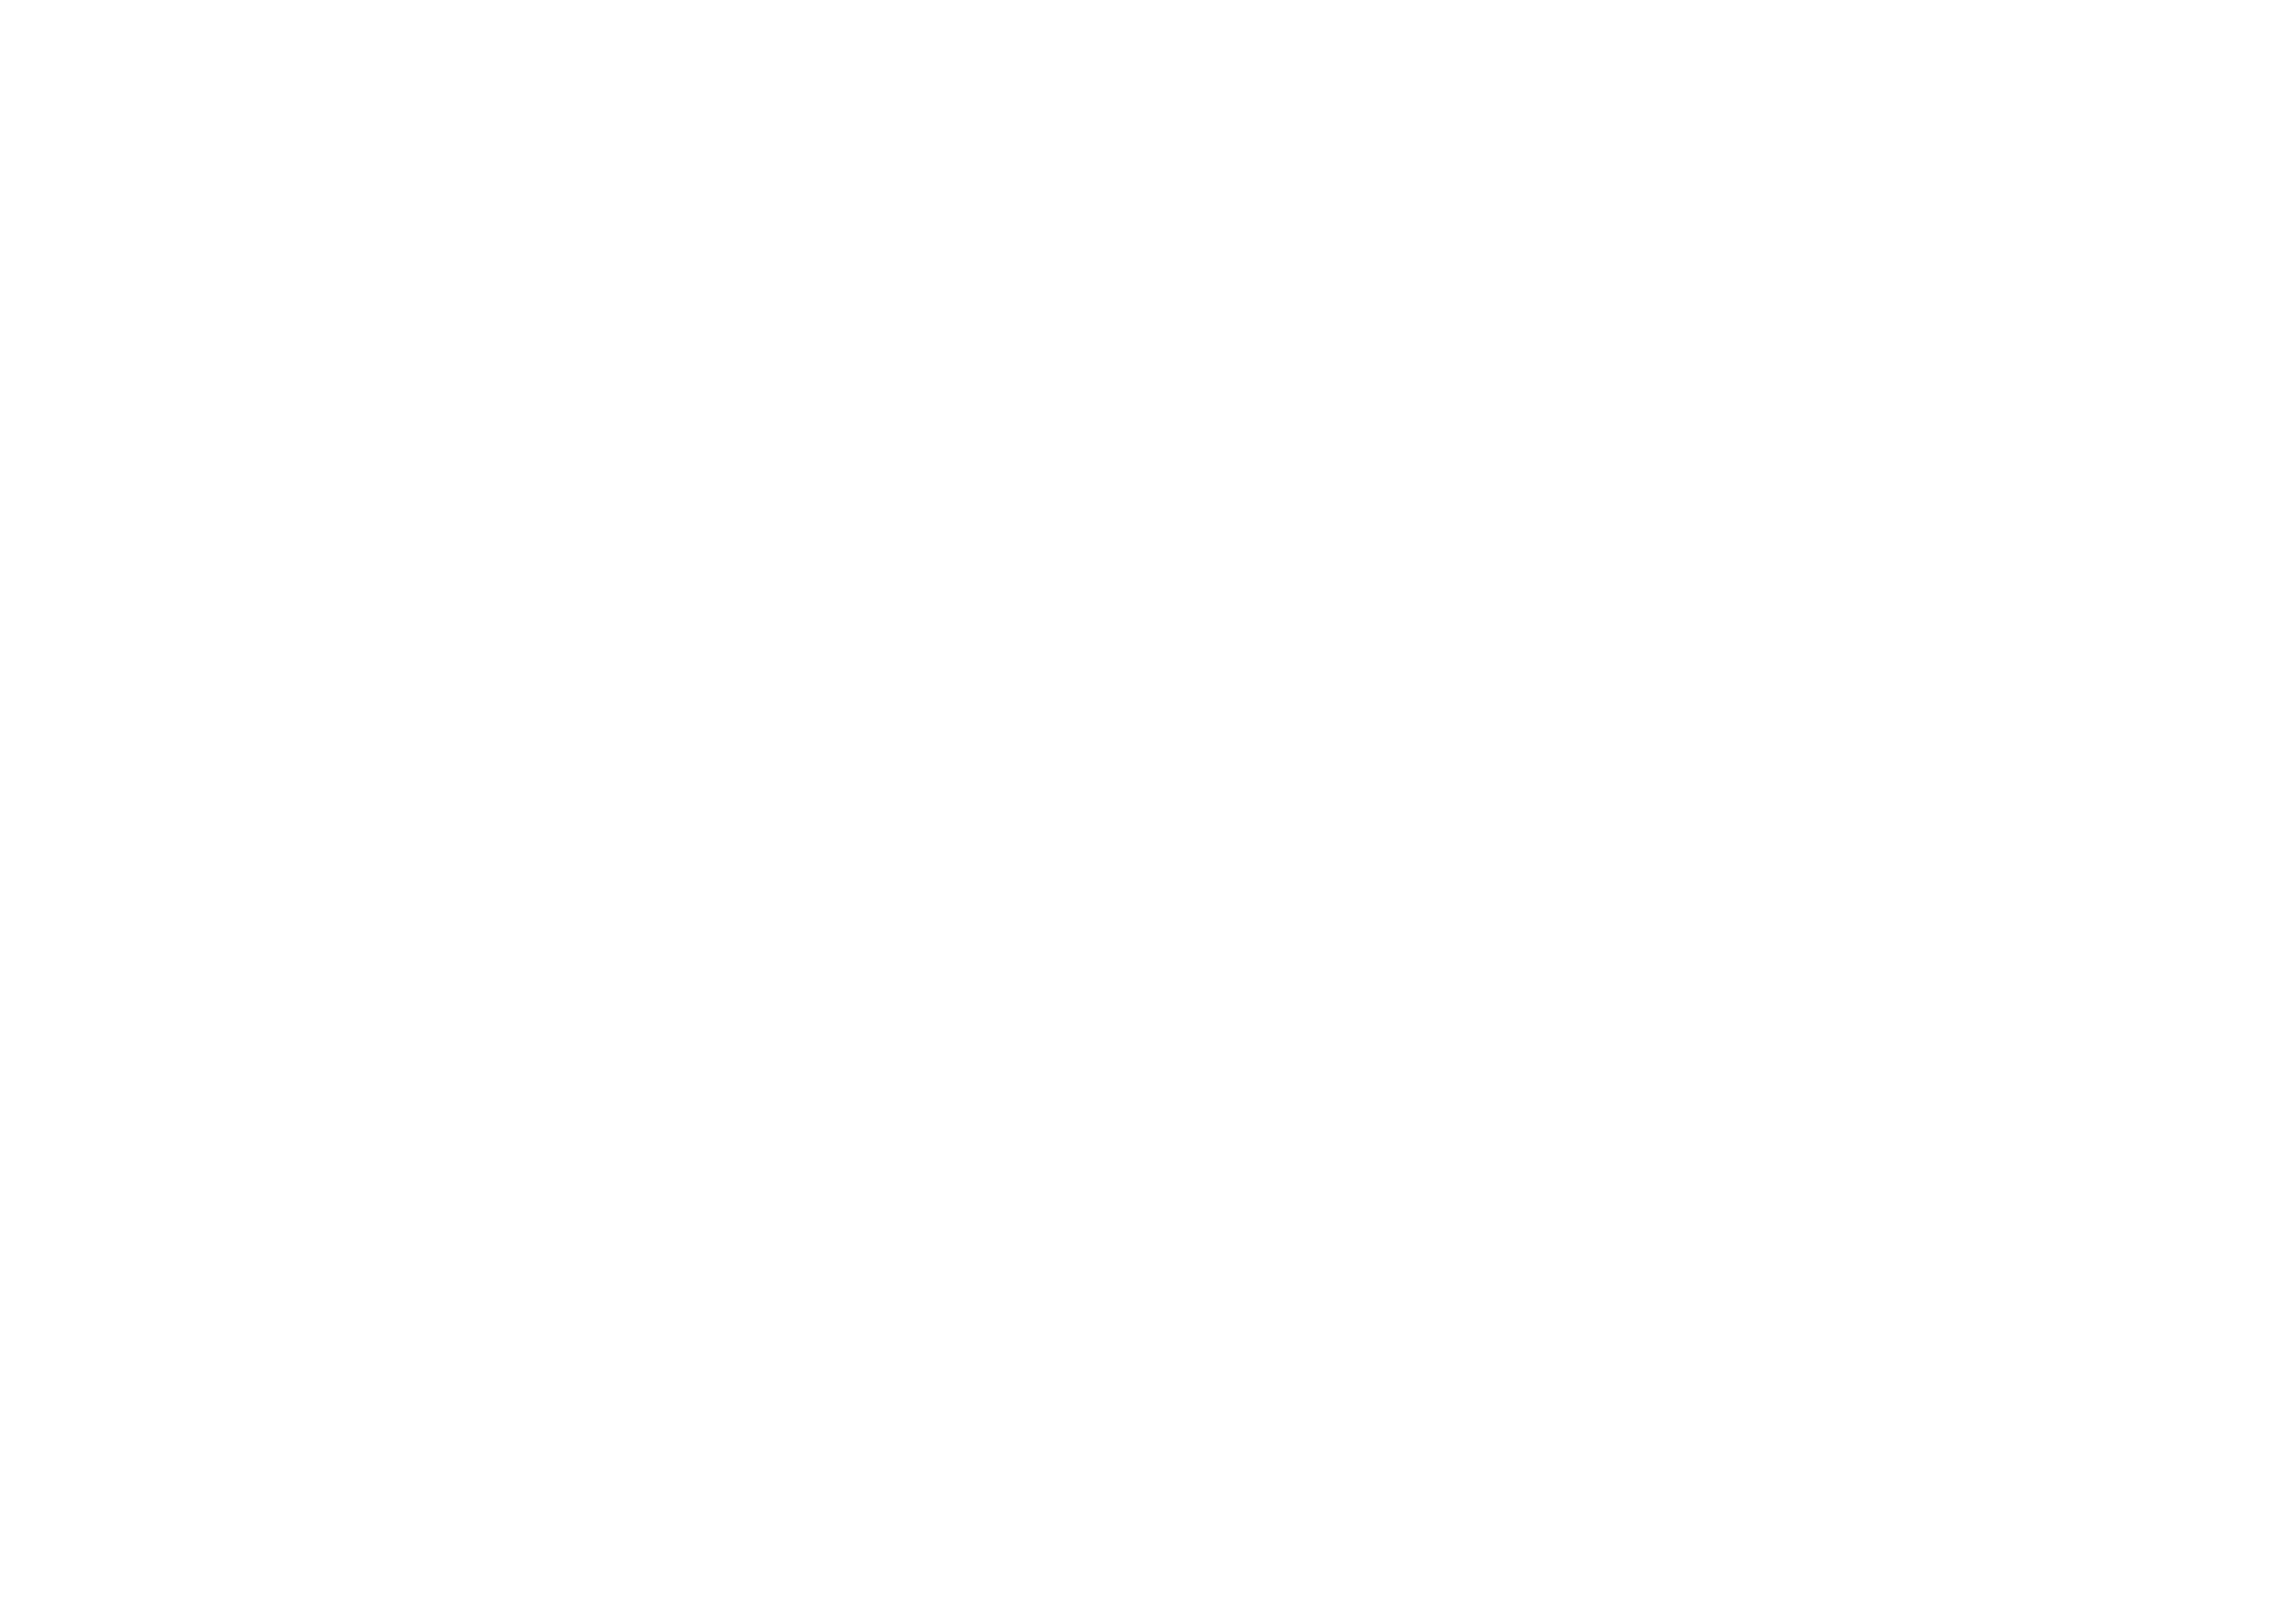

In [333]:
fig, ax = plt.subplots(figsize =(60,44))
ax.set_facecolor('#0f0f0f')
ax.grid(False)
for z in range(lat_bins+total_break):
    dftmp = elevation_data[(elevation_data['RowID'] == z+1) & (elevation_data['Elevation'] >0) ]
    if len(dftmp) > 5:
        ax.plot(dftmp['Longitude'],dftmp['Latitude_Elev'],linestyle = 'solid',c= 'w',linewidth=3.0)

plt.axis('off')
plt.savefig('mtl_elevation.png',pad_inches=0,facecolor = '#0f0f0f',bbox_inches = 'tight')